In [11]:
# %matplotlib qt
# %matplotlib ipympl

In [12]:
## Imports
print("Importing...")
import re
import copy
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import cv2
import easyocr

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.widgets import Slider


Importing...


In [15]:
########################################################
##########               INPUTS               ##########
########################################################

VIDEO_PATH = "Videos/Start5.avi"
# VIDEO_PATH = None
rules = dict(re_rule=r'-?\d{1,3}\.\d', )
RECOGNIZABLE_VARIABLES = [
    dict(name='Viscosity', rules=rules),
    dict(name='Temperature', rules=rules),
]


In [16]:
## Global settings
if VIDEO_PATH is None:
    input_path = ''
    while input_path == '':
        input_path = input(f"Input video path: ")
    VIDEO_PATH = input_path

CAP = cv2.VideoCapture(VIDEO_PATH)
FPS = int(CAP.get(cv2.CAP_PROP_FPS))
LENTH = int(CAP.get(cv2.CAP_PROP_FRAME_COUNT) / FPS)
CAP.set(cv2.CAP_PROP_POS_FRAMES, 0)
_, START_FRAME = CAP.read()


In [17]:
## Image processor
class ImageProcessor:
    blur=1

    def __call__(self, image):
        image = cv2.blur(image, (self.blur, self.blur))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.bitwise_not(image)
        return image

Configurate image processing


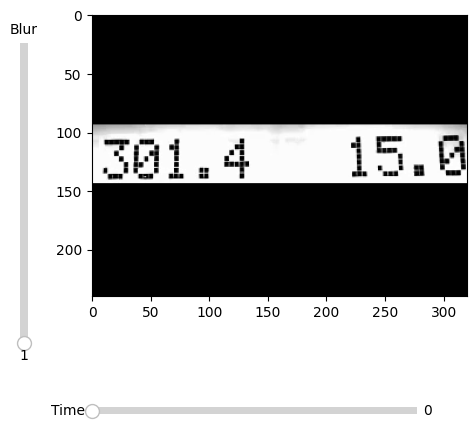

In [18]:
## Setup processor confings
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
fig.subplots_adjust(left=0.25, right=1, bottom=0.25, top=1, hspace=0, wspace=0)

image_processor = ImageProcessor()
PLOT = ax.imshow(image_processor(START_FRAME), cmap='binary')

ax_time_slider = fig.add_axes([0.25, 0.1, 0.65, 0.03])
TIME_slider = Slider(
    ax=ax_time_slider,
    label='Time',
    valmin=0,
    valmax=LENTH,
    valinit=0,
    valstep=1,
)

ax_blur_slider = fig.add_axes([0.1, 0.25, 0.03, 0.6])
BLUR_slider = Slider(
    ax=ax_blur_slider,
    orientation='vertical',
    label='Blur',
    valmin=image_processor.blur,
    valmax=20,
    valinit=1,
    valstep=1,
)


def update(val):
    time = TIME_slider.val
    global image_processor
    image_processor.blur = BLUR_slider.val

    CAP.set(cv2.CAP_PROP_POS_FRAMES, int(FPS * time))
    _, frame = CAP.read()
    frame = image_processor(frame)

    PLOT.set_data(frame)
    PLOT.autoscale()

    fig.canvas.draw_idle()


TIME_slider.on_changed(update)
BLUR_slider.on_changed(update)
print('Configurate image processing')
plt.show()

Blur value= 1


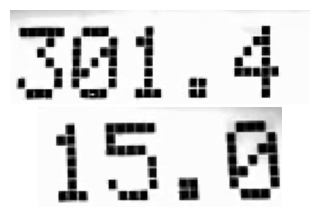

In [19]:
## Selection
def strict(image, x, y, w, h):
    return image[y:y + h, x:x + w]


print(f'Blur value= {image_processor.blur}')
for variable in RECOGNIZABLE_VARIABLES:
    roi_frame = image_processor(START_FRAME)
    roi_frame = cv2.bitwise_not(roi_frame)
    current_slice = cv2.selectROI(
        f"Select {variable['name']}",
        roi_frame,
        fromCenter=False,
        showCrosshair=True,
    )
    variable['slice'] = current_slice
cv2.destroyAllWindows()

# Result plots
fig, axes = plt.subplots(nrows=len(RECOGNIZABLE_VARIABLES))
fig.set_t
if not isinstance(axes, np.ndarray): axes = [axes]
fig.set_size_inches(3, 1 * len(RECOGNIZABLE_VARIABLES))
fig.subplots_adjust(left=0, right=1, bottom=0.0, top=1, hspace=0, wspace=0)
start_slices = [
    strict(image_processor(START_FRAME), *variable['slice'])
    for variable in RECOGNIZABLE_VARIABLES
]
for i in range(len(RECOGNIZABLE_VARIABLES)):
    axes[i].set_axis_off()
    axes[i].imshow(start_slices[i], cmap='binary')
plt.show()

In [28]:
class ValueChecker:
    def check(self, image, raw_value, rules):
        pattern_check = self._pattern_check(raw_value[0], **rules)
        if pattern_check is not None: return pattern_check

        img_check = self._image_check(image, rules)
        if img_check is not None: return img_check

        # value_check = self._value_check(raw_value)
        # if value_check is not None: return value_check
        
    def __init__(self, processor: ImageProcessor, reader):
        self._processor = processor
        self._reader = reader

    def _pattern_check(
        self,
        value: str,
        re_rule=None,
        min_rule=None,
        max_rule=None,
    ):
        value = value.replace(',', '.')
        one_check = len(re.findall(re_rule, value)) == 1
        try:
            value = float(value)
        except ValueError:
            return None
        min_check = value <= min_rule if min_rule is not None else True
        max_check = value >= max_rule if max_rule is not None else True

        result = value if one_check and min_check and max_check else None
        return result

    def _value_check(self, raw_value: list):
        parts = len(raw_value)
        if parts == 1:
            try:
                check_result = float(raw_value[0])
                if check_result > 1000:
                    raw_result = str(check_result)
                    raw_result = raw_result[:3] + '.' + raw_result[4]
            except:
                raw_result = None

        elif parts == 2:
            raw_result = '.'.join(raw_value)

        elif parts == 3:
            raw_result = f'{raw_value[0]}.{raw_value[2]}'

        try:
            result = float(raw_result)
        except:
            result = None
        return result

    def _image_check(self, image, rules):
        processor = copy.deepcopy(self._processor)
        # TODO: configure sweep
        for i in range(1, 20):
            processor.blur = i
            processed_img = processor(image=image)
            raw_value = [
                value for _, value, _ in self._reader.readtext(processed_img)
            ]
            result = self._pattern_check(raw_value[0], **rules)
            if result is not None:
                return result

In [29]:
## Recognize
print('Starting recognizer...')
reader = easyocr.Reader(['en'])
checker = ValueChecker(reader=reader, processor=image_processor)

input_fps = input('Input number of frames per second: ')
try:
    read_fps = float(input_fps)
except:
    read_fps = 1

print('Recognizing:')
errors = 0
frame_line = tqdm(iterable=range(0, FPS * LENTH, int(FPS / read_fps)))
frame_line.set_description(f'Errors: {errors: >4}')
data = []
for i_frame in frame_line:
    CAP.set(cv2.CAP_PROP_POS_FRAMES, i_frame)
    _, frame = CAP.read()
    i_text = {'time': round(i_frame / FPS, 1)}
    for variable in RECOGNIZABLE_VARIABLES:
        selection = strict(frame, *variable['slice'])
        processed_img = image_processor(selection)
        raw_value = [value for _, value, _ in reader.readtext(processed_img)]
        
        result = checker.check(image=selection,
                               raw_value=raw_value,
                               rules=variable['rules'])
        i_text[variable['name']] = result

    if None in i_text.values():
        errors += 1
        frame_line.set_description(f'Errors: {errors: >4}')
    data.append(i_text)
# pd.DataFrame(data)

Starting recognizer...
Recognizing:


Errors:   88: 100%|██████████| 129/129 [00:13<00:00,  9.90it/s]


In [30]:
pd.DataFrame(data)

,time,Viscosity,Temperature
0,0.0,NaN,NaN
1,1.0,NaN,NaN
2,2.0,302.4,NaN
3,3.0,NaN,NaN
4,4.0,302.9,NaN
...,...,...,...
124,124.0,240.9,17.4
125,125.0,240.9,17.4
126,126.0,239.9,17.4
127,127.0,239.9,17.4
